# KPI demo

This notebook demonstrates how to compute KPIs with [xlte](https://lab.nexedi.com/kirr/xlte).
It is based on [_kpidemo_](https://lab.nexedi.com/kirr/xlte/blob/master/demo/kpidemo.py)
program from that repository.

--------

As outlined in [xlte/kpi.py](https://lab.nexedi.com/kirr/xlte/blob/master/kpi.py)
module documentation the pipeline to compute a KPI is as follows:

```
    ─────────────
   │ Measurement │  Measurements   ────────────────       ──────
   │             │ ─────────────→ │ MeasurementLog │ ──→ │ Calc │ ──→  KPI
   │   driver    │                 ────────────────       ──────
    ─────────────
```

Below we will organize this pipeline and execute it step by step.

**Step 1**.
Setup driver to provide measurements data.<br>
Such a driver is specific to eNB implementation. Below we use [amari.kpi.LogMeasure](https://lab.nexedi.com/kirr/xlte/blob/master/amari/kpi.py) that is
specific to Amarisoft and retrieves measurements data from _enb.xlog_ . The _enb.xlog_ itself was produced by [amari.xlog](https://lab.nexedi.com/kirr/xlte/blob/master/amari/xlog.py) module via running `xamari xlog ws://localhost:9001 stats/15s` command on the eNodeB.

In [1]:
from xlte.amari import kpi as akpi
from urllib.request import urlopen

xlog_uri = "https://lab.nexedi.com/kirr/misc/raw/162307b9/lte/20221211-overload.xlog"
fxlog = urlopen(xlog_uri)
alogm = akpi.LogMeasure(fxlog,  # amari.kpi.LogMeasure converts enb.xlog into kpi.Measurements
                        open('/dev/null', 'r'))

**Step 2**. Setup [kpi.MeasurementLog](https://lab.nexedi.com/kirr/xlte/blob/master/kpi.py) and load measurements data into it.<br>
The data, as contained in the measurement log, is kept there in the form
of [kpi.Measurement](https://lab.nexedi.com/kirr/xlte/blob/master/kpi.py), which is driver-independent representation for
KPI-related measurement data.

In [2]:
from xlte import kpi

mlog = kpi.MeasurementLog()
try:
    while 1:
        m = alogm.read()
        if m is None:
            break
        mlog.append(m)
finally:
    alogm.close()

**Step 3**. Compute E-RAB Accessibility KPI over _MeasurementLog_ with specified granularity period.<br>
We partition entries in the measurement log by specified time period and further use [kpi.Calc](https://lab.nexedi.com/kirr/xlte/blob/master/kpi.py) to compute the KPI over each period.

In [3]:
tperiod = 1*60  # 1 minute
vτ = []
vInititialEPSBEstabSR = []
vAddedEPSBEstabSR     = []

τ = mlog.data()[0]['X.Tstart']
for m in mlog.data()[1:]:
    τ_ = m['X.Tstart']
    if (τ_ - τ) >= tperiod:
        calc = kpi.Calc(mlog, τ, τ+tperiod)
        vτ.append(calc.τ_lo)
        τ = calc.τ_hi
        _ = calc.erab_accessibility()
        vInititialEPSBEstabSR.append(_[0])
        vAddedEPSBEstabSR    .append(_[1])

**Step 4**. Plot computed KPI.<br>
The E-RAB Accessibility KPI has two parts: _initial E-RAB establishment
success rate_, and _additional E-RAB establishment success rate_. [kpi.Calc](https://lab.nexedi.com/kirr/xlte/blob/master/kpi.py)
provides both of them in the form of their confidence intervals. The
lower margin of the confidence interval coincides with 3GPP definition of
the KPI. The upper margin, however, provides information of how
confident, or how unsure we are about described value. For example if
there is enough data to compute the KPI precisely during particular
period, the low and high margins of the confidence interval will be the
same. However if, during a period, there is no measurements data at all,
the confidence interval will be \[0,100\] meaning full uncertainty - because
there is no measurements data we don't know how accessible eNB was during
that period of time. The width of a confidence interval is not
necessarily 100. For example if during a period, there is no measurement
data only for part of that period, the KPI value is computed from the
other times in the period when there is data, and the confidence interval
will be thinner.

For each of the parts we plot both its lower margin and the whole
confidence interval area.

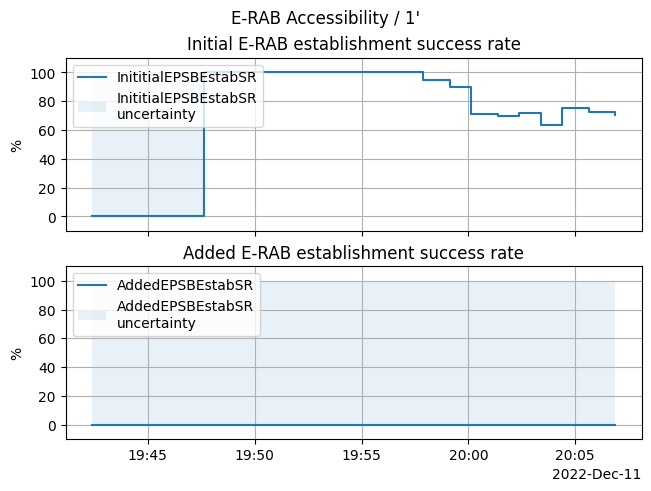

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, layout='constrained')
pmin, psec = divmod(tperiod, 60) 
fig.suptitle("E-RAB Accessibility / %s%s" % ("%d'" % pmin if pmin else '', 
                                             '%d"' % psec if psec else ''))
ax1.set_title("Initial E-RAB establishment success rate")
ax2.set_title("Added E-RAB establishment success rate")

vτ = [datetime.fromtimestamp(_) for _ in vτ] 
def plot1(ax, v, label):  # plot1 plots KPI data from vector v on ax.
    v = np.asarray(v)
    ax.plot(vτ, v['lo'], drawstyle='steps-post', label=label)
    ax.fill_between(vτ, v['lo'], v['hi'],
                    step='post', alpha=0.1, label='%s\nuncertainty' % label)

plot1(ax1, vInititialEPSBEstabSR, "InititialEPSBEstabSR")
plot1(ax2, vAddedEPSBEstabSR,     "AddedEPSBEstabSR")

for ax in (ax1, ax2):
    ax.set_ylabel("%")
    ax.set_ylim([0-10, 100+10])
    ax.set_yticks([0,20,40,60,80,100])

    xloc = mdates.AutoDateLocator()
    xfmt = mdates.ConciseDateFormatter(xloc)
    ax.xaxis.set_major_locator(xloc)
    ax.xaxis.set_major_formatter(xfmt)

    ax.grid(True)
    ax.legend(loc='upper left')

plt.show()

The plot corresponds to scenario with 3 parts:

1. the first part is "silence" - when there is no mobiles around and so the base station is not being used by UEs at all. As the base station is not being used we don't know the probablity of successfully establishing an E-RAB. This is reflected by [0,100] confidence interval that means "full uncertainty".

2. the second period is when 5 UE start to attach and detach to eNB constantly. Each mobile attaches for 20 seconds and does a ping test, then goes to power_off for 5 seconds. The base station can handle that just ok with all E-RAB establishment requests succeeding. This is reflected by *InititialEPSBEstabSR*=100%.

3. The third period is when 100 UE are around the base station. They all try to do the same power_on+ping+power_off test from "2", but since the number of UE is high, the base station gets overloaded and cannot attach them all. This is reflected by decreased *InititialEPSBEstabSR*.

In this test there was no additional E-RAB established, so *AddedEPSBEstabSR* is full uncertainty all the time.

END